In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from math import pi # for radar chart

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('allcars.csv', index_col=0).reset_index(drop=True)

In [5]:
df = df.drop(['accData'], axis=1)

In [6]:
df.head()

,timeStamp,tripID,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos,deviceID
0,2017-10-31 18:45:59.000000,0,2.2,14.48,NaN,NaN,44.313725,NaN,NaN,0.0,0.0,903.0,4.0,NaN,15.686275,1
1,2017-10-31 18:46:00.000000,0,3.7,14.48,NaN,NaN,35.294118,NaN,NaN,0.0,0.0,938.0,6.0,NaN,15.294118,1
2,2017-10-31 18:46:01.000000,0,3.9,14.54,NaN,NaN,29.411765,NaN,NaN,0.0,0.0,1044.5,7.0,NaN,14.901961,1
3,2017-10-31 18:46:02.000000,0,3.9,14.56,NaN,NaN,53.725490,NaN,NaN,0.0,0.0,1102.0,7.0,NaN,17.647059,1
4,2017-10-31 18:46:03.000000,0,4.7,14.48,NaN,NaN,75.686275,NaN,NaN,0.0,0.0,1626.5,10.0,NaN,23.529412,1


In [7]:
df['deviceID'].nunique()

29

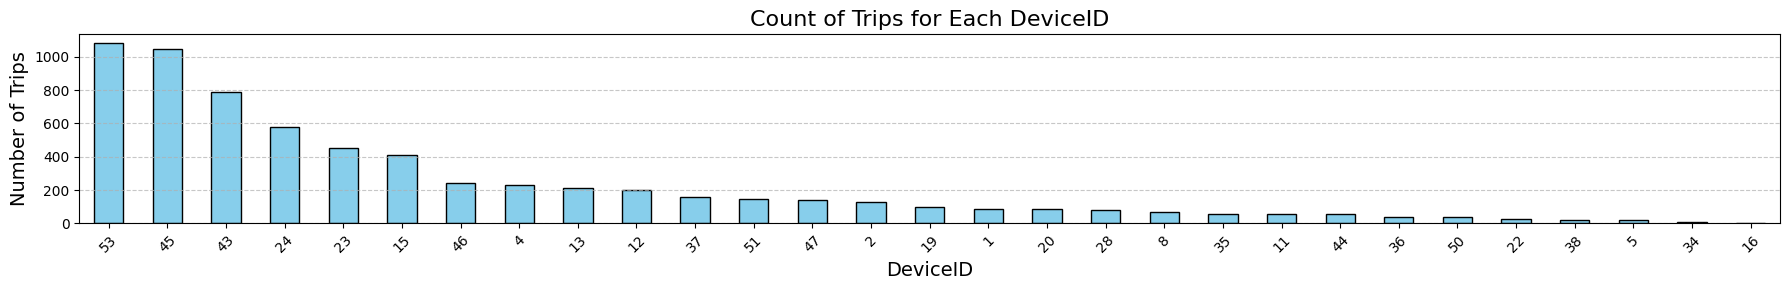

In [8]:
import matplotlib.pyplot as plt

# Count the number of trips for each deviceID
trip_counts = df.groupby('deviceID')['tripID'].nunique()

# Plot the bar chart
plt.figure(figsize=(18, 3))
trip_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Count of Trips for Each DeviceID', fontsize=16)
plt.xlabel('DeviceID', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# Count the number of trips for each deviceID
trip_counts = df.groupby('deviceID')['tripID'].nunique()

# Sort the counts in ascending order and get the 5 lowest values
lowest_trip_counts = trip_counts.sort_values(ascending=True).head(5)

# Print the results
print("Top 5 DeviceIDs with the Lowest Number of Trips:")
print(lowest_trip_counts)

Top 5 DeviceIDs with the Lowest Number of Trips:
deviceID
16     1
34    10
38    22
5     22
22    27
Name: tripID, dtype: int64


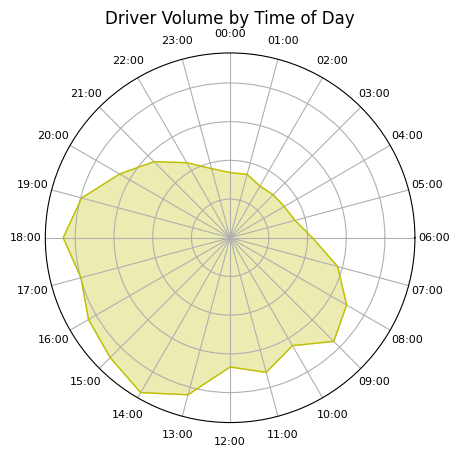

In [10]:
# radar chart to visualize distribution of datapoints by the hour
hour_buckets = pd.to_datetime(df['timeStamp']).dt.hour.value_counts().sort_index()
hours, hour_counts = hour_buckets.index.to_list(), hour_buckets.to_list()

# rotate by 90 degrees counter clockwise so the chart is more
# intuitive, then reverse
hours = (hours[7:] + hours[:7])[::-1]
hour_counts = (hour_counts[7:] + hour_counts[:7])[::-1]

# turn hours into a reader-friendly format
hours = [str(h).zfill(2) + ':00' for h in hours]

hour_counts.append(hour_counts[0])
N = len(hours)
angles = [i / float(N) * 2 * pi for i in range(N)]
angles.append(angles[0])

ax = plt.subplot(polar=True)
plt.title('Driver Volume by Time of Day\n')
plt.xticks(angles[:-1], hours, size=8)
ax.set_yticklabels([])
ax.plot(angles, hour_counts, color='y', linewidth=1)
ax.fill(angles, hour_counts, alpha=0.3, color='y')
plt.show()

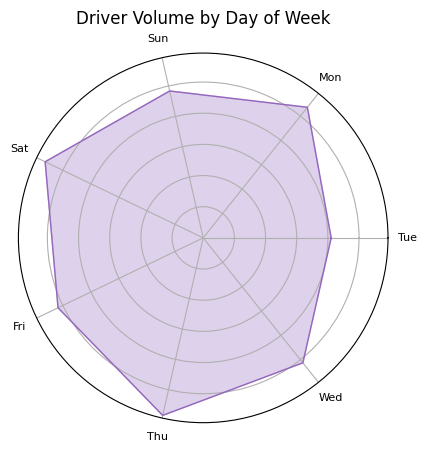

In [11]:
# radar chart to visualize distribution of datapoints by the day of week
wd_buckets = pd.to_datetime(df['timeStamp']).dt.weekday.value_counts().sort_index()
weekdays, wd_counts = wd_buckets.index.to_list(), wd_buckets.to_list()
wd_list = [
    'Mon',
    'Tue',
    'Wed',
    'Thu',
    'Fri',
    'Sat',
    'Sun'
]
weekdays = [wd_list[x] for x in weekdays]

# rotate counter clockwise so the chart is more
# intuitive, then reverse
weekdays = (weekdays[2:] + weekdays[:2])[::-1]
wd_counts = (wd_counts[2:] + wd_counts[:2])[::-1]

wd_counts.append(wd_counts[0])
N = len(weekdays)
angles = [i / float(N) * 2 * pi for i in range(N)]
angles.append(angles[0])

ax = plt.subplot(polar=True)
plt.title('Driver Volume by Day of Week\n')
plt.xticks(angles[:-1], weekdays, size=8)
ax.set_yticklabels([])
ax.plot(angles, wd_counts, color='tab:purple', linewidth=1)
ax.fill(angles, wd_counts, alpha=0.3, color='tab:purple')
plt.show()

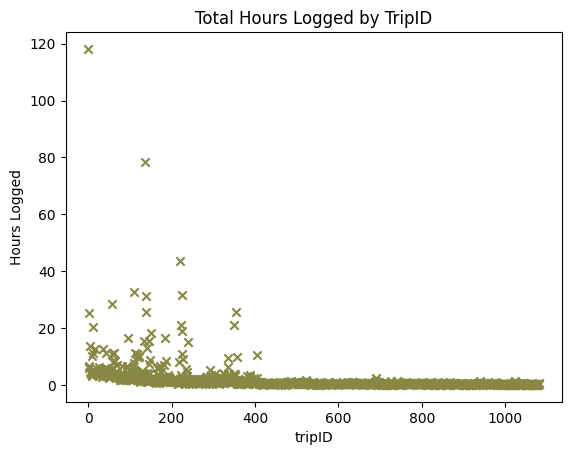

In [12]:
hours_by_trip = df['tripID'].value_counts()/(60*60)
plt.scatter(x=hours_by_trip.index, y=hours_by_trip,
           color='#888844', marker='x')
plt.title('Total Hours Logged by TripID')
plt.xlabel('tripID')
plt.ylabel('Hours Logged')
plt.show()

In [13]:
hours_by_trip.sort_values(ascending=False).head(5)

tripID
0      118.153056
136     78.261111
220     43.567500
109     32.806667
224     31.734444
Name: count, dtype: float64

In [14]:
total_trip_ids = hours_by_trip.index.tolist()
print("Total Trip IDs:", len(total_trip_ids))

Total Trip IDs: 1082


In [15]:
valid_trips = hours_by_trip[(hours_by_trip >= 0.1) & (hours_by_trip <= 40)]

valid_trip_ids = valid_trips.index.tolist()
print("Valid Trip IDs:", len(valid_trip_ids))

Valid Trip IDs: 1050


In [16]:
df = df[df['tripID'].isin(valid_trip_ids)]

In [17]:
def handle_missing_values_device_level(df):
    # List of numerical columns to impute
    numerical_columns = ['battery', 'cTemp', 'eLoad', 'iat', 'imap', 'kpl', 'maf', 'rpm', 'speed', 'tAdv', 'tPos']
    
    # Group by 'deviceID' and fill missing values with the mean for each device
    df_imputed = df.copy()
    for col in numerical_columns:
        # For each column, group by 'deviceID' and fill NaN values with the mean of the group
        df_imputed[col] = df.groupby('deviceID')[col].transform(lambda x: x.fillna(x.mean() if not x.isnull().all() else 0))
    
    return df_imputed

# Apply the function
df = handle_missing_values_device_level(df)

In [18]:
# filtering out suspiciously high speed measurements
df = df[df['speed'] < 157]
# tPos has a very thick right tail which is extremely unlikely
df = df[df['tPos'] < 80]

In [19]:
import pandas as pd

# Ensure 'battery' and 'gps_speed' columns are filled with mean values for NaNs
df['battery'] = df['battery'].fillna(df['battery'].mean())
df['gps_speed'] = df['gps_speed'].fillna(df['gps_speed'].mean())

# Replace infinite values with 0 for 'battery' and 'gps_speed'
df['battery'] = df['battery'].replace([float('inf'), -float('inf')], 0)
df['gps_speed'] = df['gps_speed'].replace([float('inf'), -float('inf')], 0)

# Calculate acceleration
df.loc[:, 'timeStamp'] = pd.to_datetime(df['timeStamp'])
df.sort_values(by='timeStamp', inplace=True)
df['timeDelta'] = df['timeStamp'].diff().dt.total_seconds()
df = df[(df['timeDelta'] == 1.0)]
df['diff'] = df['speed'].diff()
df['acceleration'] = df['diff'] / df['timeDelta']
df = df.drop(['diff', 'timeDelta'], axis=1)

# Fill NaN values in 'acceleration' with 0
df['acceleration'].fillna(0, inplace=True)

# Feature engineering
df['hard_brake'] = (df['acceleration'] < -3).astype(int)
df['high_speed'] = (df['gps_speed'] > 80).astype(int)
df['high_throttle'] = (df['tPos'] > 60).astype(int)
df['aggressive_acceleration'] = (df['acceleration'] > 3).astype(int)
df['inefficient_driving'] = ((df['rpm'] > 4000) & (df['gps_speed'] < 30)).astype(int)
df['excessive_idling'] = ((df['gps_speed'] < 5) & (df['tPos'] < 10)).astype(int)

# Calculate 'fuel_efficiency' after ensuring no NaNs or infinite values in 'battery' and 'gps_speed'
df['fuel_efficiency'] = df['battery'] / df['gps_speed']

# Replace infinite values in 'fuel_efficiency' with 0
df['fuel_efficiency'] = df['fuel_efficiency'].replace([float('inf'), -float('inf')], 0)

# Check if NaNs still exist in 'fuel_efficiency'
df['fuel_efficiency'].fillna(0, inplace=True)

# Fill NaN values with the column's mean for continuous features
df['rpm'] = df['rpm'].fillna(df['rpm'].mean())
df['tPos'] = df['tPos'].fillna(df['tPos'].mean())

In [20]:
# Verify if there are any NaNs remaining
print(df.isnull().sum())

timeStamp                        0
tripID                           0
gps_speed                        0
battery                          0
cTemp                            0
dtc                        3044232
eLoad                            0
iat                              0
imap                             0
kpl                              0
maf                              0
rpm                              0
speed                            0
tAdv                             0
tPos                             0
deviceID                         0
acceleration                     0
hard_brake                       0
high_speed                       0
high_throttle                    0
aggressive_acceleration          0
inefficient_driving              0
excessive_idling                 0
fuel_efficiency                  0
dtype: int64


In [21]:
# Step 3: Aggregation by tripID with percentage calculations
df_trip_agg = df.groupby(['tripID', 'deviceID']).agg({
    'acceleration': ['mean', 'std'],
    'gps_speed': ['max', 'mean', 'std'],
    'battery': 'mean',
    'rpm': ['mean', 'max'],
    'speed': 'mean',
    'tPos': 'mean',
    'hard_brake': 'mean',  # Calculate percentage of hard brakes
    'high_speed': 'mean',  # Calculate percentage of high-speed records
    'high_throttle': 'mean',  # Calculate percentage of high throttle usage
    'aggressive_acceleration': 'mean',  # Percentage of aggressive acceleration
    'inefficient_driving': 'mean',  # Percentage of inefficient driving
    'excessive_idling': 'mean',  # Percentage of excessive idling
    'fuel_efficiency': 'mean'
}).reset_index()

df_trip_agg = df_trip_agg.fillna(0)

# Flatten multi-level columns
df_trip_agg.columns = ['_'.join(col).strip() for col in df_trip_agg.columns.values]

In [22]:
df_trip_agg = df_trip_agg[df_trip_agg['gps_speed_mean'] > 0]

# Optionally, reset the index after filtering
df_trip_agg.reset_index(drop=True, inplace=True)

In [23]:
# Count the number of trips for each deviceID
trip_counts = df_trip_agg.groupby('deviceID_')['tripID_'].nunique()

# Sort the counts in ascending order and get the 5 lowest values
lowest_trip_counts = trip_counts.sort_values(ascending=True).head(5)

# Print the results
print("Top 5 DeviceIDs with the Lowest Number of Trips:")
print(lowest_trip_counts)

Top 5 DeviceIDs with the Lowest Number of Trips:
deviceID_
51     3
34     8
38    17
46    19
5     20
Name: tripID_, dtype: int64


In [24]:
df_trip_agg.head()

,tripID_,deviceID_,acceleration_mean,acceleration_std,gps_speed_max,gps_speed_mean,gps_speed_std,battery_mean,rpm_mean,rpm_max,speed_mean,tPos_mean,hard_brake_mean,high_speed_mean,high_throttle_mean,aggressive_acceleration_mean,inefficient_driving_mean,excessive_idling_mean,fuel_efficiency_mean
0,1,4,0.000000,0.000000,10.353362,10.353362,0.000000,12.512599,1173.217542,1173.217542,0.000000,6.076303,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.208554
1,1,8,0.000000,0.000000,10.353362,10.353362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,1,12,-0.014583,3.532332,60.800000,17.300417,13.169915,11.248307,1407.880208,2899.000000,30.697917,15.655229,0.039583,0.0,0.0,0.021875,0.0,0.153125,2.069424
3,1,15,0.000000,0.000000,10.353362,10.353362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,1,23,-5.387931,15.682605,35.400000,7.739224,7.636672,0.000000,660.506466,1763.000000,8.659483,0.000000,0.262931,0.0,0.0,0.094828,0.0,0.383621,0.000000


In [25]:
print(df_trip_agg.isnull().sum())

tripID_                         0
deviceID_                       0
acceleration_mean               0
acceleration_std                0
gps_speed_max                   0
gps_speed_mean                  0
gps_speed_std                   0
battery_mean                    0
rpm_mean                        0
rpm_max                         0
speed_mean                      0
tPos_mean                       0
hard_brake_mean                 0
high_speed_mean                 0
high_throttle_mean              0
aggressive_acceleration_mean    0
inefficient_driving_mean        0
excessive_idling_mean           0
fuel_efficiency_mean            0
dtype: int64


In [26]:
df_trip_agg.count()

tripID_                         5026
deviceID_                       5026
acceleration_mean               5026
acceleration_std                5026
gps_speed_max                   5026
gps_speed_mean                  5026
gps_speed_std                   5026
battery_mean                    5026
rpm_mean                        5026
rpm_max                         5026
speed_mean                      5026
tPos_mean                       5026
hard_brake_mean                 5026
high_speed_mean                 5026
high_throttle_mean              5026
aggressive_acceleration_mean    5026
inefficient_driving_mean        5026
excessive_idling_mean           5026
fuel_efficiency_mean            5026
dtype: int64

In [27]:
def calculate_feature_score(feature_value, thresholds):
    """
    Calculate the score for a specific feature based on thresholds.
    
    Parameters:
    - feature_value (float): The value of the feature for a particular trip.
    - thresholds (tuple): The (low, medium, high) thresholds for the feature.
    
    Returns:
    - float: The normalized score for the feature based on its threshold.
    """
    if feature_value <= thresholds[0]:
        return 0  # Low threshold: score 0 (Harsh Driving)
    elif feature_value <= thresholds[1]:
        return 0.5  # Medium threshold: score 0.5 (Safe Driving)
    else:
        return 1  # High threshold: score 1 (Efficient Driving)

def calculate_driving_score(row, thresholds):
    """
    Calculate the overall driving score for a single trip (row) based on its features and thresholds.
    
    Parameters:
    - row (pd.Series): The row containing feature values for a particular trip.
    - thresholds (dict): Dictionary of feature names and their corresponding (low, medium, high) thresholds.
    
    Returns:
    - float: The overall driving score, scaled between 0 and 1.
    """
    score = 0
    total_weight = len(thresholds)  # Equal weight for each feature for simplicity
    
    for feature, feature_thresholds in thresholds.items():
        feature_value = row[feature]
        score += calculate_feature_score(feature_value, feature_thresholds)
    
    # Normalize score to be between 0 and 1
    return score / total_weight  # Ensures the score is between 0 and 1

def apply_clustering_scores(df, features, thresholds):
    """
    Apply the score calculation to all rows in the DataFrame and assign cluster labels.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the features for each trip.
    - features (list): List of selected feature names.
    - thresholds (dict): Dictionary of feature names and their corresponding (low, medium, high) thresholds.
    
    Returns:
    - pd.DataFrame: DataFrame with added 'score' and cluster assignments.
    """
    # Apply the scoring function to each row
    df['score'] = df[features].apply(lambda row: calculate_driving_score(row, thresholds), axis=1)
    
    # Cluster the data based on the calculated score
    df['cluster'] = df['score'].apply(lambda score: 0 if score < 0.30 else (1 if score < 0.65 else 2))
    
    return df

def calculate_statistics(df, features):
    """
    Calculate min, max, mean, and mode for each feature in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing feature values for each trip.
    - features (list): List of feature names to calculate statistics for.
    
    Returns:
    - dict: A dictionary containing min, max, mean, and mode for each feature.
    """
    stats = {}
    
    for feature in features:
        min_value = df[feature].min()
        max_value = df[feature].max()
        mean_value = df[feature].mean()
        mode_value = df[feature].mode()[0]  # Assuming the mode is the most frequent value
        
        stats[feature] = {
            'min': min_value,
            'max': max_value,
            'mean': mean_value,
            'mode': mode_value
        }
    
    return stats

def define_dynamic_thresholds(stats, feature):
    """
    Define thresholds based on the min, max, mean, and mode of a feature.
    
    Parameters:
    - stats (dict): The dictionary containing statistics for each feature.
    - feature (str): The feature for which to define thresholds.
    
    Returns:
    - tuple: A tuple containing (low, medium, high) thresholds for the feature.
    """
    min_val = stats[feature]['min']
    max_val = stats[feature]['max']
    mean_val = stats[feature]['mean']
    mode_val = stats[feature]['mode']
    
    # Defining thresholds based on mean, mode, and range between min and max
    low = min_val
    high = max_val
    
    # If the mean and mode are close, we set medium threshold to mean or mode
    medium = mean_val if abs(mean_val - mode_val) <= 0.1 * mean_val else mode_val
    
    return (low, medium, high)

def apply_dynamic_thresholds(df, features):
    """
    Apply dynamic thresholds to features based on min, max, mean, and mode statistics.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing feature values for each trip.
    - features (list): List of selected feature names.
    
    Returns:
    - dict: Dictionary with dynamic thresholds for each feature.
    """
    stats = calculate_statistics(df, features)
    dynamic_thresholds = {}
    
    for feature in features:
        dynamic_thresholds[feature] = define_dynamic_thresholds(stats, feature)
    
    return dynamic_thresholds

# Example usage:
features = [
    'acceleration_mean', 'acceleration_std', 'gps_speed_max', 'gps_speed_mean', 'gps_speed_std',
    'battery_mean', 'rpm_mean', 'rpm_max', 'speed_mean', 'tPos_mean', 'hard_brake_mean',
    'high_speed_mean', 'high_throttle_mean', 'aggressive_acceleration_mean', 
    'inefficient_driving_mean', 'excessive_idling_mean', 'fuel_efficiency_mean'
]

# Assuming df_trip_agg is your DataFrame
dynamic_thresholds = apply_dynamic_thresholds(df_trip_agg, features)
print(dynamic_thresholds)

# You can now use this dynamic_thresholds in your scoring functions
df_trip_score = apply_clustering_scores(df_trip_agg, features, dynamic_thresholds)

# Group by 'deviceID_' to calculate the mode of clusters for each device
df_device_cluster = df_trip_score.groupby('deviceID_').agg(
    cluster=('cluster', lambda x: x.mode()[0]),  # Get the most frequent cluster (mode)
    score=('score', 'mean')  # Calculate the average score for the device
).reset_index()

# Print the resulting DataFrame with deviceID, cluster (mode), and score
print(df_device_cluster[['deviceID_', 'cluster', 'score']])

{'acceleration_mean': (np.float64(-103.3578947368421), np.float64(0.0), np.float64(64.87777777777778)), 'acceleration_std': (np.float64(0.0), np.float64(0.0), np.float64(59.39696961966999)), 'gps_speed_max': (np.float64(0.001), np.float64(10.353361650765631), np.float64(276.58)), 'gps_speed_mean': (np.float64(0.0006097560975609756), np.float64(10.456723567611213), np.float64(64.8)), 'gps_speed_std': (np.float64(0.0), np.float64(0.0), np.float64(34.33475898127005)), 'battery_mean': (np.float64(0.0), np.float64(0.0), np.float64(14.665965317919076)), 'rpm_mean': (np.float64(0.0), np.float64(0.0), np.float64(3447.700273224044)), 'rpm_max': (np.float64(0.0), np.float64(0.0), np.float64(14849.75)), 'speed_mean': (np.float64(0.0), np.float64(0.0), np.float64(117.0)), 'tPos_mean': (np.float64(0.0), np.float64(0.0), np.float64(68.75816993464053)), 'hard_brake_mean': (np.float64(0.0), np.float64(0.0), np.float64(1.0)), 'high_speed_mean': (np.float64(0.0), np.float64(0.0), np.float64(0.0674486803

In [28]:
# Define a combined mapping with both driving style and price category
combined_mapping = {
    0: 'Efficient Driving - Premium (80%)',        # Cluster 0: Safe driving behavior with Premium pricing
    1: 'Safe Driving - Standard (100%)',     # Cluster 1: Harsh driving behavior with Standard pricing
    2: 'Harsh Driving - Extra Charge (120%)' # Cluster 2: Efficient driving behavior with Extra charge pricing
}

# Apply combined labels to the DataFrame
df_device_cluster['driving_style_and_price'] = df_device_cluster['cluster'].map(combined_mapping)

# Sort the DataFrame by driving style for better clarity
sorted_vehicle_cluster = df_device_cluster.sort_values(by='driving_style_and_price')

# Print the sorted table with deviceID and combined driving style + price category
print(sorted_vehicle_cluster[['deviceID_', 'driving_style_and_price']])

    deviceID_              driving_style_and_price
12         28    Efficient Driving - Premium (80%)
15         36    Efficient Driving - Premium (80%)
13         34    Efficient Driving - Premium (80%)
8          15    Efficient Driving - Premium (80%)
10         20    Efficient Driving - Premium (80%)
18         43  Harsh Driving - Extra Charge (120%)
17         38  Harsh Driving - Extra Charge (120%)
16         37  Harsh Driving - Extra Charge (120%)
14         35  Harsh Driving - Extra Charge (120%)
23         51  Harsh Driving - Extra Charge (120%)
0           1  Harsh Driving - Extra Charge (120%)
6          12  Harsh Driving - Extra Charge (120%)
2           4  Harsh Driving - Extra Charge (120%)
24         53  Harsh Driving - Extra Charge (120%)
11         23       Safe Driving - Standard (100%)
7          13       Safe Driving - Standard (100%)
5          11       Safe Driving - Standard (100%)
4           8       Safe Driving - Standard (100%)
3           5       Safe Drivin

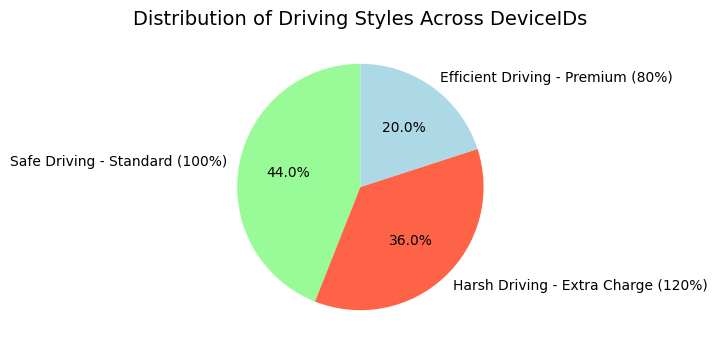

In [29]:
# Count the occurrences of each driving style
driving_style_counts = df_device_cluster['driving_style_and_price'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(driving_style_counts, labels=driving_style_counts.index, 
        autopct='%1.1f%%', startangle=90, colors=['#98FB98', '#FF6347', '#ADD8E6'])

# Title
plt.title('Distribution of Driving Styles Across DeviceIDs', fontsize=14)

# Show the plot
plt.show()
